### Importing libraries

In [682]:
import numpy as np
from scipy.sparse import diags, bmat, eye
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from matplotlib.ticker import LinearLocator
from sympy import solve, symbols, lambdify
from matplotlib.gridspec import GridSpec

### Preliminary functions for plotting, convergence and constructing matrices

In [683]:
def plot_solution(x, y, U, ax, txt='Solution'):
    X, Y = np.meshgrid(x,y)
    ax.plot_surface(X, Y, U, cmap=cm.Spectral)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.w_zaxis.set_major_formatter(ticker.FormatStrFormatter('%2.2e'))
    ax.set_title(txt)
    plt.setp(ax.get_zticklabels(), rotation=30, horizontalalignment='left', fontsize='x-small')

In [684]:
def tridiag_sparse(a,b,c,N):
    bidiag_l = np.full(N-1, a)
    diag = np.full(N, b)
    bidiag_u = np.full(N-1, c)
    
    A = diags([bidiag_l, diag, bidiag_u],[-1,0,1])
    return A

In [685]:
def block_tridiag_sparse(A, B, C, N ):
    A = bmat([[B if i == j else A if i-j==-1 else C if i-j==1 else None for i in range(N)] for j in range(N)], format='csc')
    return A

In [739]:
def convergence(u_exact, g, f, solver, P=4, M=50, **kwargs): 
    Hconv, Econv = np.zeros(P), np.zeros(P)
    for p in range(P):
        x, y, U = solver(g, f, M, **kwargs)
        X, Y = np.meshgrid(x,y)
        Eh = u_exact(X,Y)-U
        Hconv[p] = (x[1]-x[0])
        M = 2*M
        Econv[p]=np.max(np.abs(Eh)) #inf norm
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

### PDE solvers

#### Problem 1

In [687]:
def solve_PDE1a(g, f, M, **kwargs):
    a = kwargs['a']
    h = 1/M
    k = 2*h
    print(f"h = {h:.4}, k = {k:.4}")
    
    x = np.linspace(0,1,M+1)
    y = np.linspace(0,2,M+1)
    g_dict = g(x,y)
    
    U = np.zeros((M+1, M+1))
    U[0,:] = g_dict["lower"]
    U[-1,:] = g_dict["upper"]
    U[:,0] = g_dict["left"]
    U[:,-1] = g_dict["right"]
    
    #diags of B
    B = tridiag_sparse(-a, 2*(a+1), -a, M-1)
    C = diags(np.full(M-2,-1),1)
    A = block_tridiag_sparse(C.T, B, C, B.shape[0])
    
    X, Y = np.meshgrid(x[1:-1], y[1:-1])
  
    f_vec = np.ravel(f(X,Y, a))
    
    b_vec = np.zeros((M-1)**2)
    b_vec[1:M-1] = g_dict["lower"][1:M-1]
    b_vec[-(M-1):-1] = g_dict["upper"][-(M-1):-1] 
    b_vec[:-(M-1)+1:M-1] += a*g_dict["left"][1:-1]+g_dict["left"][:M-1] 
    b_vec[(M-1)-1::M-1] += a*g_dict["right"][1:-1]+g_dict["right"][-(M-1):]
    
    U[1:-1,1:-1] = np.reshape(spsolve(A, b_vec+f_vec*h**2), (M-1,M-1))
    
    return x, y, U

In [688]:
def solve_PDE1d(g, f, M, **kwargs):
    a, r = kwargs['a'], kwargs['r'] 
    h = 1/M
    k = abs(r)*h
    
    print(f"h = {h:.4}, k = {k:.4}")
    
    N = int(2//k)+1 #number of inner horizontal gridlines
    
    x = np.linspace(0,1, M+1)
    y = np.linspace(0,k*N, N+1, endpoint=True)
    y[-1] = 2 
    g_dict = g(x,y)
   
    U = np.zeros((N+1, M+1))
    U[:,-1] = g_dict["right"]
    U[0,:] = g_dict["lower"]
    U[-1,:] = g_dict["upper"]
    U[:,0] = g_dict["left"]
    #y[-1]=k*N
    
    B = tridiag_sparse(-a, 2*(a+1), -a, M-1)
    C = diags(np.full(M-2,-1),1)
    
    X, Y = np.meshgrid(x[1:-1], y[1:-1])
  
    f_vec = np.ravel(f(X,Y, a, r))
    
    b_vec = np.zeros((M-1)*(N-1))
    if r < 0:
        A = block_tridiag_sparse(C, B, C.T, N-1)
        b_vec[:M-2] = g_dict["lower"][-(M-1):-1]
        b_vec[-(M-1)+1:] = g_dict["upper"][1:M-1] 
        b_vec[:-(M-1)+1:M-1] += a*g_dict["left"][1:-1]+g_dict["left"][-(N-1):] 
        b_vec[(M-1)-1::M-1] += a*g_dict["right"][1:-1]+g_dict["right"][:N-1]
        
    else:
        A = block_tridiag_sparse(C.T, B, C, N-1)
        b_vec[1:M-1] = g_dict["lower"][1:M-1]
        b_vec[-(M-1):-1] = g_dict["upper"][-(M-1):-1] 
        b_vec[:-(M-1)+1:M-1] += a*g_dict["left"][1:-1]+g_dict["left"][:N-1] 
        b_vec[(M-1)-1::M-1] += a*g_dict["right"][1:-1]+g_dict["right"][-(N-1):]
    
    U[1:-1,1:-1] = np.reshape(spsolve(A, b_vec+f_vec*h**2), (N-1,M-1))
    return x, y, U

#### Problem 2

In [735]:
def solve_PDE2i(g, f, M, **kwargs):
    #defining boundary (gamma3), and fattened boundary (sqrt(2)h away from gamma3)  
    gamma3 = lambda x : 1-x**2
    fattened_boundary = lambda x, h : (-8*x**2*h**2 - (-4*np.sqrt(2)*x**2 - np.sqrt(2))*np.sqrt(4*x**2 + 1)*h - 4*x**4 + 3*x**2 + 1) / (4*x**2 + 1)
    
    h = 1/M
    print(f"h = {h:.4}")
    
    x = np.linspace(0,1,M+1)
    y = np.linspace(0,1,M+1)
    X,Y = np.meshgrid(x,y)
    indices = np.reshape(np.linspace(0,(M+1)**2-1, (M+1)**2, dtype=np.int64),(M+1,M+1))
    g_dict = g(x,y)
    
    inner_nodes = np.logical_and(Y<gamma3(X), np.logical_and(X>0, Y>0))
    inner_indices = indices[inner_nodes]
    
    fattened_boundary_nodes = np.logical_and(gamma3(X)<=Y, np.logical_and(np.logical_and(X>0, Y>0), Y<fattened_boundary(X,h)))
    fattened_boundary_indices = indices[fattened_boundary_nodes]
    
    U = np.zeros((M+1, M+1))
    U[0,:] = g_dict["lower"]
    U[:,0] = g_dict["left"]
    U=U.ravel()

    #projecting points on boundary onto curve
    xx, yy, r = symbols('xx yy r', real=True, positive=True)
    sol=solve(xx+r*(1-2*yy)-2*r**3, r)
    np_sol = lambdify((xx, yy), sol[-1])
    x_proj = np_sol(X[fattened_boundary_nodes],Y[fattened_boundary_nodes]) #x-coordinate of projected points
    y_proj = gamma3(x_proj) #y-coordinate of projected points
 
    U[fattened_boundary_indices] = g(x_proj, y_proj)["curve"]
    
    num_inner_row = inner_nodes.sum(axis=1)[1:-1] #number of inner nodes in each row
    num_inner_col = inner_nodes.sum(axis=0)[1:-1] #number of inner nodes in each column

    A = bmat([[tridiag_sparse(-1,4,-1, num_inner_row[i]) if i == j \
               else -eye(num_inner_row[i], num_inner_row[j]) if abs(j-i)==1 \
               else None for j in range(len(num_inner_row))] for i in range(len(num_inner_row))], format='csc')
    
    f_vec = f(X[inner_nodes],Y[inner_nodes])
    b = np.zeros(len(inner_indices))
    
    #indices of b, where we need to add boundary conditions to the RHS
    b_ind_right = np.cumsum(num_inner_row)-1 #need to add point to the right
    b_ind_left = np.cumsum(np.concatenate(([0], num_inner_row[:-1]))) #left
    b_ind_down = np.arange(num_inner_row[0]) #down
    b_ind_up = np.cumsum(np.concatenate(([0], num_inner_row[:-1])))[num_inner_col-1]+np.arange(num_inner_row[0]) #up
    
    #indices of boundary values to be added in b
    U_ind_right = (np.arange(len(num_inner_row))+1)*(M+1) + num_inner_row + 1
    U_ind_up = (num_inner_col+1)*(M+1) + np.arange(len(num_inner_col)) + 1
    
    #adding points to b at indices
    b[b_ind_right] += U[U_ind_right]
    b[b_ind_left] += g_dict["left"][1:-1]
    b[b_ind_down] += g_dict["lower"][1:-1]
    b[b_ind_up] +=  U[U_ind_up]
    
    U[inner_indices] = spsolve(A, h**2*f_vec + b)
    U = U.reshape((M+1,M+1))
    U[Y>gamma3(X)] = 0
    
    return x, y, U

In [748]:
def solve_PDE2ii(g, f, M, **kawrgs):
    #defining curved boundary, gamma3 
    gamma3 = lambda x : 1-x**2
    
    h = 1/M
    print(f"h = {h:.4}")
    
    x = np.linspace(0,1,M+1)
    y = np.linspace(0,1,M+1)
    X,Y = np.meshgrid(x,y)
    Xu, Yu = X.ravel(), Y.ravel()
    indices = np.reshape(np.linspace(0,(M+1)**2-1, (M+1)**2, dtype=np.int64),(M+1,M+1)) 
    g_dict = g(x,y)
    
    inner_nodes = np.logical_and(Y<gamma3(X), np.logical_and(X>0, Y>0))
    inner_indices = indices[inner_nodes]
    
    U = np.zeros((M+1, M+1))
    U[0,:] = g_dict["lower"]
    U[:,0] = g_dict["left"]
    y_vals = Y[Y==gamma3(X)]
    x_vals = np.sqrt(1-y_vals)
    U[Y==gamma3(X)] = g(x_vals, y_vals)["curve"]
    U=U.ravel()
    
    num_inner_row = inner_nodes.sum(axis=1)[1:-1] #number of inner nodes in each row, left to right
    num_inner_col = inner_nodes.sum(axis=0)[1:-1] #number of inner nodes in each column, down to up
    
    f_vec = f(X[inner_nodes],Y[inner_nodes])

    #creating system matrix. Will have to modify some elements accoring to the boundary conditions
    A = bmat([[tridiag_sparse(-1,4,-1, num_inner_row[i]) if i == j \
               else -eye(num_inner_row[i], num_inner_row[j]) if abs(j-i)==1 \
               else None for j in range(len(num_inner_row))] for i in range(len(num_inner_row))], format='csc')
    
    #indices of the inner nodes, named according to the neighbor they have on the boundary (will be added to the RHS vector b)
    inner_ind_right = np.cumsum(num_inner_row)-1 #right neighbor is on the boundary
    inner_ind_left = np.cumsum(np.concatenate(([0], num_inner_row[:-1]))) #left neighbor on boundary
    inner_ind_down = np.arange(num_inner_row[0]) #down
    inner_ind_up = np.cumsum(np.concatenate(([0], num_inner_row[:-1])))[num_inner_col-1]+np.arange(num_inner_row[0]) #up
    
    #indices of boundary values to be added in b
    grid_ind_right = (np.arange(len(num_inner_row))+1)*(M+1) + num_inner_row
    grid_ind_up = (num_inner_col)*(M+1) + np.arange(len(num_inner_col)) + 1
    
    xcurve = np.sqrt(1-Yu[grid_ind_right]) #x-coordinate of boundary points on curve
    ycurve = 1-(Xu[grid_ind_up])**2 #y-coordinate of boundary points on curve
    
    etay = (ycurve-Yu[grid_ind_up])/h
    etax = (xcurve-Xu[grid_ind_right])/h

    #altered coefficients due to nodes on the boundary
    a_left = -2/(etax + 1)
    a_right = -2/(etax*(etax + 1))
    a_x = 2/etax

    a_up = -2/(etay + 1)
    a_down = -2/(etay*(etay + 1))
    a_y = 2/etay

    intersection_ind = np.intersect1d(inner_ind_right, inner_ind_up) #all nodes with two neighbors on the boundary (up and right)
    union_ind = np.union1d(inner_ind_right, inner_ind_up) #all nodes with at least one neighbor node on the boundary

    A[union_ind, union_ind] = 2 #nodes with only one neighbor node on the boundary get 2 as a coefficient from the other direction
    A[intersection_ind, intersection_ind] = 0 #nodes with two neighbors on the boundary get contributions from both a_x and a_y below
    A[inner_ind_right, inner_ind_right] += a_x #adding coefficients for nodes with right neighbor on boundary
    A[inner_ind_up, inner_ind_up] += a_y #adding coefficients for nodes with upper neighbor on boundary

    A[inner_ind_right, inner_ind_right-1] = a_left #also need to update coeffecient to the left of a node that has a right boundary neighbor
    add_down = inner_ind_up[inner_ind_up>num_inner_row[0]-1] #nodes where we need to update the coefficient of the lower neighbor
    A[add_down, add_down - (num_inner_row[num_inner_col-2])[:len(add_down)]] = a_down[:len(add_down)] #updating the lower coefficients

    b = np.zeros(len(inner_indices))
    b[inner_ind_right] -= g(xcurve, gamma3(xcurve))["curve"]*a_right
    b[inner_ind_up] -= g(np.sqrt(1-ycurve), ycurve)["curve"]*a_up
    b[:num_inner_row[0]-1] += g_dict["lower"][1:-2]
    #b[np.intersect(inner_ind_down, np.arange(num_inner_row[0]))] = boundary["lower"][]*a_down[]
    b[num_inner_row[0]-1] -= g_dict["lower"][-1]*a_down[-1]
    b[inner_ind_left] += g_dict["left"][1:-1]
    
    U[inner_indices] = spsolve(A, h**2*f_vec + b)
    U = U.reshape((M+1,M+1))
    
    return x, y, U

### Results

#### 1a)

h = 0.01, k = 0.02


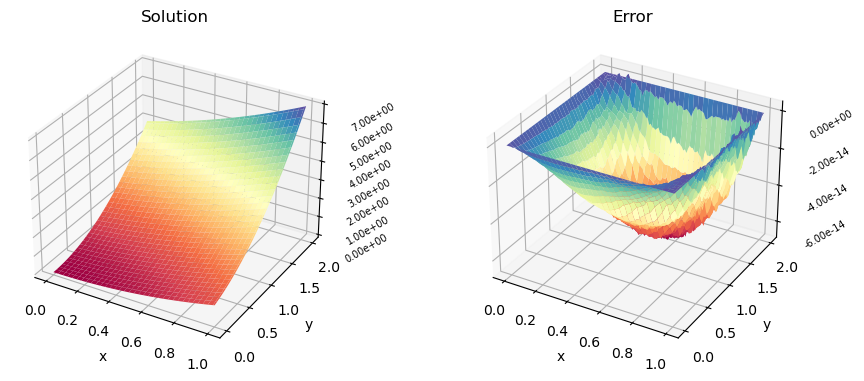

In [691]:
def u(x, y):
    return x**2 + y**2 + x*y

def f(x, y, a):
    return -(2*a+14)

def g(x,y):
    lower = x**2
    upper = x**2+4+2*x
    left = y**2
    right = 1+y**2+y
    boundary = {"left": left, "right": right, "lower":lower, "upper": upper}
    return boundary

x, y, U = solve_PDE1a(g, f, M=100, a=1)
X, Y = np.meshgrid(x, y)


fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10,5))
plot_solution(x, y, U, axs[0], "Solution")
plot_solution(x, y, U-u(X, Y), axs[1],"Error")
fig.tight_layout(pad=6)
plt.show()

#### 1c)

h = 0.01, k = 0.02
h = 0.02, k = 0.04
h = 0.01, k = 0.02
h = 0.005, k = 0.01
h = 0.0025, k = 0.005


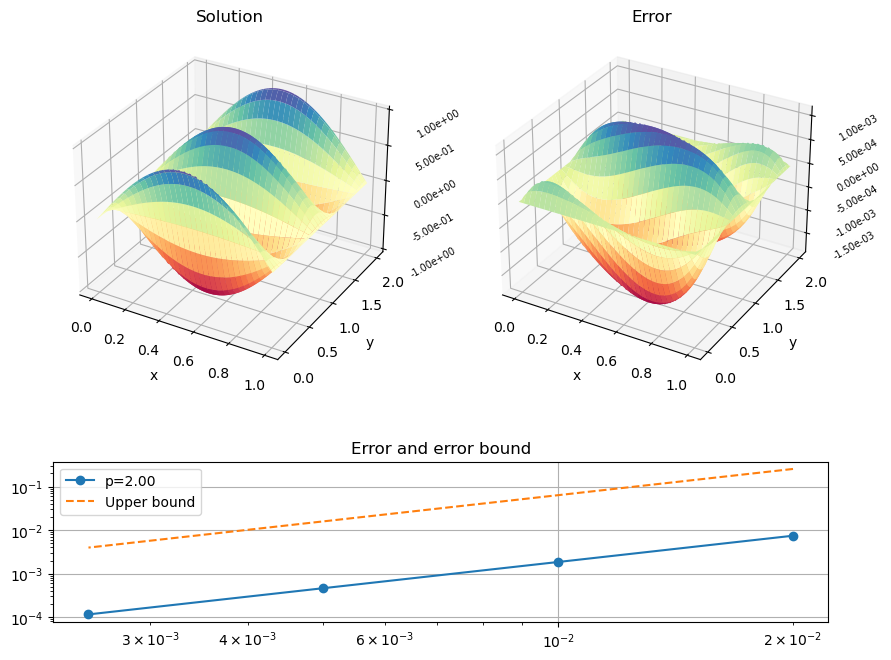

In [712]:
def u(x, y):
    return np.cos(np.pi*y*2)*np.sin(np.pi*x)

def f(x, y, a):
    a1 = -np.pi**2 *(a+1)*np.cos(2*np.pi*y)*np.sin(np.pi*x)
    a2=-8*np.pi**2*np.cos(np.pi*x)*np.sin(2*np.pi*y)
    a3 = -16*np.pi**2*np.cos(2*np.pi*y)*np.sin(np.pi*x)
    return -(a1+a2+a3)

def g(x,y):
    lower = np.sin(np.pi*x)
    upper = np.sin(np.pi*x)
    left = np.full(len(x), 0)
    right = np.full(len(x), 0)
    
    boundary = {"left": left, "right": right, "lower":lower, "upper": upper}
    return boundary

x, y, U = solve_PDE1a(g, f, M=100, a=1)
X, Y = np.meshgrid(x, y)
H, E, p = convergence(u, g, f, solve_PDE1a, P=4, M=50, a=1)


fig = plt.figure(figsize=(10,8))
axs = [0,0,0]
gs = GridSpec(2, 2, height_ratios=[5,2])
axs[0] = fig.add_subplot(gs[0,0], projection='3d')
axs[1] = fig.add_subplot(gs[0,1], projection='3d')
axs[2] = fig.add_subplot(gs[1,:])
plot_solution(x, y, U, axs[0], "Solution")
plot_solution(x, y, U-u(X, Y), axs[1],"Error")
axs[2].loglog(H, E, "o-", label="p={:.2f}".format(p))
axs[2].loglog(H, (H**2*313/48*np.pi**4), "--", label="Upper bound")
axs[2].grid("on")
axs[2].set_title("Error and error bound")
axs[2].legend()
#fig.tight_layout(pad=6)
plt.savefig("1c1.png")
plt.show()

h = 0.01, k = 0.02
h = 0.02, k = 0.04
h = 0.01, k = 0.02
h = 0.005, k = 0.01
h = 0.0025, k = 0.005


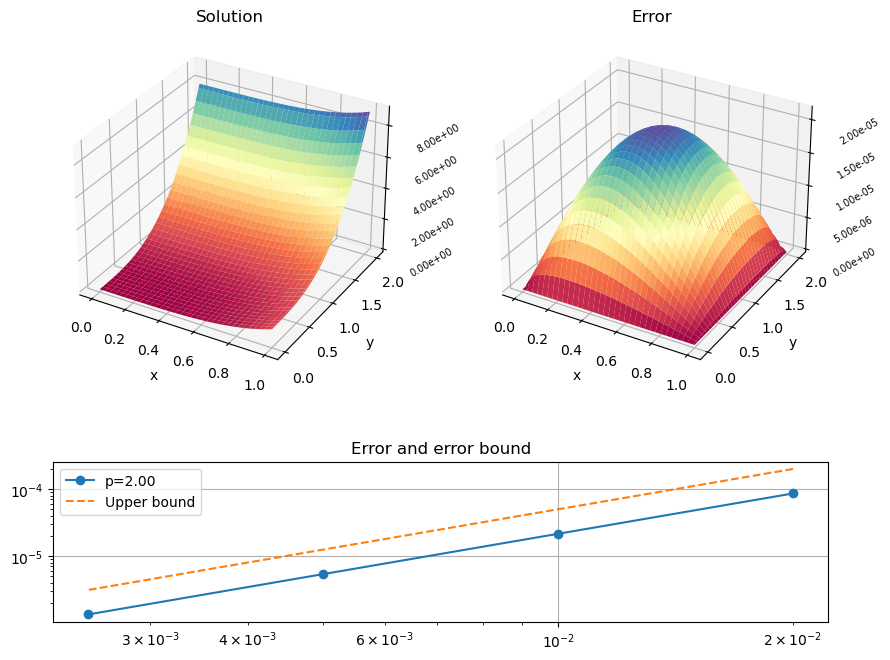

In [717]:
def u(x,y):
    return x**4+y**3

def f(x,y,a):
    return -(1+a)*4*3*x**2-4*3*2*y

def g(x,y):
    lower = x**4
    upper = x**4+2**3
    left = y**3
    right = 1+y**3
    
    boundary = {"left": left, "right": right, "lower":lower, "upper": upper}
    return boundary

x, y, U = solve_PDE1a(g, f, M=100, a=1)
X, Y = np.meshgrid(x, y)
H, E, p = convergence(u, g, f, solve_PDE1a, P=4, M=50, a=1)


fig = plt.figure(figsize=(10,8))
axs = [0,0,0]
gs = GridSpec(2, 2, height_ratios=[5,2])
axs[0] = fig.add_subplot(gs[0,0], projection='3d')
axs[1] = fig.add_subplot(gs[0,1], projection='3d')
axs[2] = fig.add_subplot(gs[1,:])
plot_solution(x, y, U, axs[0], "Solution")
plot_solution(x, y, U-u(X, Y), axs[1],"Error")
axs[2].loglog(H, E, "o-", label="p={:.2f}".format(p))
axs[2].loglog(H, (H**2/2), "--", label="Upper bound")
axs[2].grid("on")
axs[2].set_title("Error and error bound")
axs[2].legend()
#fig.tight_layout(pad=6)
plt.savefig("1c2.png")
plt.show()

#### 1d)

In [741]:
def u(x, y):
    return np.cos(np.pi*y*2)*np.sin(np.pi*x)

def f(x, y, a, r):
    a1 = -np.pi**2 *(a+1)*np.cos(2*np.pi*y)*np.sin(np.pi*x)
    a2= - 4*r*np.pi**2*np.cos(np.pi*x)*np.sin(2*np.pi*y)
    a3 = -(2*r)**2*np.pi**2*np.cos(2*np.pi*y)*np.sin(np.pi*x)
    return -(a1+a2+a3)

def g(x,y):
    lower = np.sin(np.pi*x)
    upper = np.sin(np.pi*x)
    left = np.full(len(y), 0)
    right = np.full(len(y), 0)
    
    boundary = {"left": left, "right": right, "lower":lower, "upper": upper}
    return boundary

x, y, U = solve_PDE1d(g, f, M=1000, a=1, r=np.pi)
X, Y = np.meshgrid(x, y)

#fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10,5))
#plot_solution(x, y, U, axs[0], "Solution")
#plot_solution(x, y, U-u(X, Y), axs[1],"Error")
#fig.tight_layout(pad=6)
#plt.show()


H, E, p = convergence(u, g, f, solve_PDE1d, P=4, M=100, a=1, r=np.pi)

fig = plt.figure(figsize=(10,8))
axs = [0,0,0]
gs = GridSpec(2, 2, height_ratios=[5,2])
axs[0] = fig.add_subplot(gs[0,0], projection='3d')
axs[1] = fig.add_subplot(gs[0,1], projection='3d')
axs[2] = fig.add_subplot(gs[1,:])
plot_solution(x, y, U, axs[0], "Solution")
plot_solution(x, y, U-u(X, Y), axs[1],"Error")
axs[2].loglog(H, E, "o-", label="p={:.2f}".format(p))
axs[2].grid("on")
axs[2].set_title("Error")
axs[2].legend()
plt.savefig("1d.png")
plt.show()

h = 0.001, k = 0.003142
h = 0.01, k = 0.03142


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

h = 0.001
h = 0.006667
h = 0.003333
h = 0.001667
h = 0.0008333


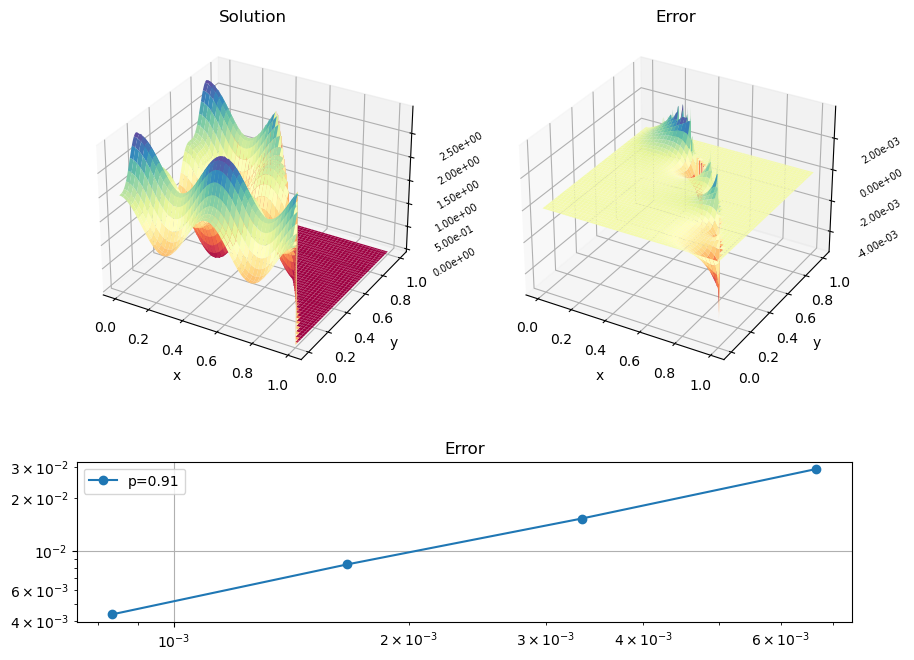

In [751]:
def u(x, y):
    return np.where(y<=1-x**2, np.cos(2* np.pi *x)**2+1+np.sin( 3*np.pi*y)**3, 0)

def g(x,y):
    gamma1 = 1+np.cos(2*np.pi*x)**2
    gamma2 = 2+np.sin(3*np.pi*y)**3
    gamma3 = 1+np.cos(2*np.pi*x)**2+np.sin(3*np.pi*(1-x**2))**3
    boundary = {"lower" : gamma1, "left" : gamma2, "curve" : gamma3 }
    return boundary

def f(x, y):
    f = ((-27 * np.pi**(2)) * (np.sin(((3 * np.pi) * y)))**(3)) \
    - ((8 * np.pi**(2)) * (np.cos(((2 * np.pi) * x)))**(2)) + ((8 * np.pi**(2)) \
    * (np.sin(((2 *np. pi) * x)))**(2)) + (((54 * np.pi**(2)) \
    * (np.cos(((3 * np.pi) * y)))**(2)) * np.sin(((3 * np.pi) * y)))
    return -f


x, y, U = solve_PDE2i(g, f, M=1000)
X, Y = np.meshgrid(x, y)
H, E, p = convergence(u, g, f, solve_PDE2i, P=4, M=150)


fig = plt.figure(figsize=(10,8))
axs = [0,0,0]
gs = GridSpec(2, 2, height_ratios=[5,2])
axs[0] = fig.add_subplot(gs[0,0], projection='3d')
axs[1] = fig.add_subplot(gs[0,1], projection='3d')
axs[2] = fig.add_subplot(gs[1,:])
plot_solution(x, y, U, axs[0], "Solution")
plot_solution(x, y, U-u(X, Y), axs[1],"Error")
axs[2].loglog(H, E, "o-", label="p={:.2f}".format(p))
axs[2].grid("on")
axs[2].set_title("Error")
axs[2].legend()
#fig.tight_layout(pad=6)
plt.savefig("2i.png")
plt.show()

h = 0.001
h = 0.006667
h = 0.003333
h = 0.001667
h = 0.0008333


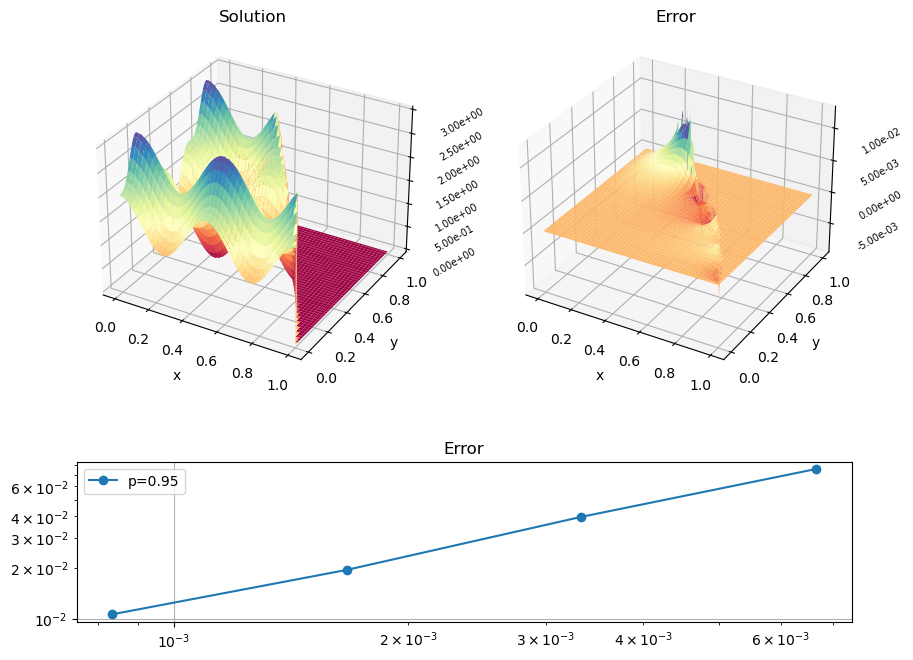

In [752]:
def u(x, y):
    return np.where(y<=1-x**2, np.cos(2* np.pi *x)**2+1+np.sin( 3*np.pi*y)**3, 0)

def g(x,y):
    gamma1 = 1+np.cos(2*np.pi*x)**2
    gamma2 = 2+np.sin(3*np.pi*y)**3
    gamma3 = 1+np.cos(2*np.pi*x)**2+np.sin(3*np.pi*(1-x**2))**3
    boundary = {"lower" : gamma1, "left" : gamma2, "curve" : gamma3 }
    return boundary

def f(x, y):
    f = ((-27 * np.pi**(2)) * (np.sin(((3 * np.pi) * y)))**(3)) \
    - ((8 * np.pi**(2)) * (np.cos(((2 * np.pi) * x)))**(2)) + ((8 * np.pi**(2)) \
    * (np.sin(((2 *np. pi) * x)))**(2)) + (((54 * np.pi**(2)) \
    * (np.cos(((3 * np.pi) * y)))**(2)) * np.sin(((3 * np.pi) * y)))
    return -f


x, y, U = solve_PDE2ii(g, f, M=1000)
X, Y = np.meshgrid(x, y)
H, E, p = convergence(u, g, f, solve_PDE2ii, P=4, M=150)


fig = plt.figure(figsize=(10,8))
axs = [0,0,0]
gs = GridSpec(2, 2, height_ratios=[5,2])
axs[0] = fig.add_subplot(gs[0,0], projection='3d')
axs[1] = fig.add_subplot(gs[0,1], projection='3d')
axs[2] = fig.add_subplot(gs[1,:])
plot_solution(x, y, U, axs[0], "Solution")
plot_solution(x, y, U-u(X, Y), axs[1],"Error")
axs[2].loglog(H, E, "o-", label="p={:.2f}".format(p))
axs[2].grid("on")
axs[2].set_title("Error")
axs[2].legend()
#fig.tight_layout(pad=6)
plt.savefig("2ii.png")
plt.show()